# Model Training

In diesem Notebook trainieren wir neuronale Netze zur Werkzeug-Erkennung. Die Daten wurden bereits im Schritt [Objektextraktion](semester-arbeit-objekt-abstraktion.ipynb) extrahiert und in ZIP-Dateien (`training_Baumstruktur.zip` und `testing_Baumstruktur.zip`) gespeichert.

Zunächst entpacken wir die bereits erstellten ZIP-Dateien mit der Baumstruktur. Die Objektbilder wurden bereits extrahiert und in Train- und Test-Ordner aufgeteilt. 

In [166]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np


In [167]:
from pathlib import Path
import zipfile
import shutil

# Entpacke ZIP-Dateien mit der Baumstruktur
Baumstrukturpfad = Path('Baumstruktur')
Baumstrukturpfad.mkdir(exist_ok=True)
trainPath = Baumstrukturpfad / "Baumstruktur_train"
testPath = Baumstrukturpfad / "Baumstruktur_test"

# WICHTIG: Leere die Ordner vor dem Entpacken, um alte Dateien zu entfernen
if trainPath.exists():
    shutil.rmtree(trainPath)
    print("✓ Train-Ordner geleert")
trainPath.mkdir(parents=True, exist_ok=True)

if testPath.exists():
    shutil.rmtree(testPath)
    print("✓ Test-Ordner geleert")
testPath.mkdir(parents=True, exist_ok=True)

# Entpacke Training-Daten
zip_train = Path('training_Baumstruktur.zip')
if zip_train.exists():
    with zipfile.ZipFile(zip_train, 'r') as zip_ref:
        zip_ref.extractall(trainPath)
    print("✓ Training-Daten entpackt")
else:
    print(f"WARNUNG: {zip_train} nicht gefunden!")

# Entpacke Test-Daten
zip_test = Path('testing_Baumstruktur.zip')
if zip_test.exists():
    with zipfile.ZipFile(zip_test, 'r') as zip_ref:
        zip_ref.extractall(testPath)
    print("✓ Test-Daten entpackt")
else:
    print(f"WARNUNG: {zip_test} nicht gefunden!") 

✓ Train-Ordner geleert
✓ Test-Ordner geleert
✓ Training-Daten entpackt
✓ Test-Daten entpackt


Die Klassen werden automatisch aus den Verzeichnisnamen erkannt. Die Baumstruktur ist bereits erstellt und enthält train- und test-Ordner mit den entsprechenden Klassen-Unterordnern.

In [168]:
# Extrahiere Klassennamen aus der Baumstruktur
# (Path und numpy sind bereits in Zelle 2 importiert)
# Verwende die bereits in Zelle 2 definierten Variablen
# Falls Baumstrukturpfad noch nicht definiert ist, definiere es hier

# Finde alle Klassen (Unterordner im Train-Ordner)
Klassennamen = [d.name for d in trainPath.iterdir() if d.is_dir()]
Klassennamen = sorted(Klassennamen)

print(f"Gefundene Klassen: {Klassennamen}")
print(f"Anzahl Klassen: {len(Klassennamen)}")

# Zähle Dateien pro Klasse
for klasse in Klassennamen:
    klasse_path = trainPath / klasse
    num_files = len(list(klasse_path.glob('*.*')))
    print(f"  {klasse}: {num_files} Dateien")

Gefundene Klassen: ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']
Anzahl Klassen: 3
  schraubenschluessel: 95 Dateien
  schraubenzieher: 94 Dateien
  seidenschneider: 99 Dateien


In [169]:
import pandas as pd

# Zähle Dateien pro Klasse im Train-Ordner
Klassenliste = []
for klasse in Klassennamen:
    klasse_path = trainPath / klasse
    files = list(klasse_path.glob('*.*'))
    Klassenliste.extend([klasse] * len(files))

Anzahl_Trainingsbeispiele = pd.Series(Klassenliste).value_counts()
print("Anzahl Trainingsbeispiele pro Klasse:")
print(Anzahl_Trainingsbeispiele)

Anzahl Trainingsbeispiele pro Klasse:
seidenschneider        99
schraubenschluessel    95
schraubenzieher        94
Name: count, dtype: int64


Die Baumstruktur ist bereits erstellt. Wir verwenden die entpackten Daten direkt. Falls nötig, können wir die Pfade hier anpassen:

In [170]:
# Verwende die bereits erstellte Baumstruktur
# Falls Baumstrukturpfad noch nicht definiert ist, definiere es hier

print(f"Train-Ordner: {trainPath}")
print(f"Test-Ordner: {testPath}")
print(f"Existiert Train: {trainPath.exists()}")
print(f"Existiert Test: {testPath.exists()}")


Train-Ordner: Baumstruktur\Baumstruktur_train
Test-Ordner: Baumstruktur\Baumstruktur_test
Existiert Train: True
Existiert Test: True


Die Baumstruktur ist bereits erstellt, daher müssen wir keine Dateien mehr kopieren. Wir können direkt mit dem Training beginnen. Die folgenden Zellen zum Kopieren werden übersprungen.

In [171]:
# Die Daten sind bereits in der richtigen Struktur, kein Kopieren nötig


print("✓ Baumstruktur ist bereit für das Training")
print(f"Train-Ordner: {trainPath}")
print(f"Test-Ordner: {testPath}")

# Erstelle ein Dictionary für die spätere Verwendung (falls benötigt)
train_or_test = {}
if 'Klassennamen' in globals():
    for klasse in Klassennamen:
        train_files = list((trainPath / klasse).glob('*.*'))
        test_files = list((testPath / klasse).glob('*.*')) if testPath.exists() else []
        for f in train_files:
            train_or_test[f.name] = 'train'
        for f in test_files:
            train_or_test[f.name] = 'test'

    print(f"\nGesamt: {len([v for v in train_or_test.values() if v == 'train'])} Train-Dateien, "
          f"{len([v for v in train_or_test.values() if v == 'test'])} Test-Dateien")
else:
    print("WARNUNG: Klassennamen noch nicht definiert. Führen Sie zuerst Zelle 4 aus.")

✓ Baumstruktur ist bereit für das Training
Train-Ordner: Baumstruktur\Baumstruktur_train
Test-Ordner: Baumstruktur\Baumstruktur_test

Gesamt: 288 Train-Dateien, 72 Test-Dateien


In [172]:
# ============================================================================
# PRÜFUNG 1: KLASSENREIHENFOLGE DOKUMENTIEREN
# ============================================================================
# Diese Prüfung dokumentiert die exakte Reihenfolge der Klassen, die beim Training verwendet wird.
# Diese Reihenfolge MUSS im Evaluation-Notebook identisch sein!

print("="*70)
print("PRÜFUNG 1: KLASSENREIHENFOLGE")
print("="*70)

if 'class_names' in globals() and 'train_ds' in globals():
    print("\n📋 Klassenreihenfolge aus train_ds.class_names:")
    print("-" * 70)
    for i, class_name in enumerate(class_names):
        print(f"  Index {i}: {class_name}")
    
    print(f"\n✓ Gesamt: {len(class_names)} Klassen")
    print(f"\n📝 WICHTIG: Diese Reihenfolge muss im Evaluation-Notebook identisch sein!")
    print(f"   → Kopieren Sie diese Reihenfolge in das Evaluation-Notebook")
    print(f"   → Oder verwenden Sie: class_names = {class_names}")
    
    # Erstelle auch ein Dictionary für die Zuordnung
    class_name_to_index = {name: idx for idx, name in enumerate(class_names)}
    print(f"\n📊 Klassen-zu-Index Mapping:")
    for name, idx in class_name_to_index.items():
        print(f"  {name:20s} → Index {idx}")
    
    print("\n" + "="*70)
    print("✓ PRÜFUNG 1 ABGESCHLOSSEN")
    print("="*70)
else:
    print("⚠ Warnung: 'class_names' oder 'train_ds' ist nicht definiert.")
    print("  Bitte führen Sie zuerst die Zelle aus, die train_ds erstellt.")


PRÜFUNG 1: KLASSENREIHENFOLGE

📋 Klassenreihenfolge aus train_ds.class_names:
----------------------------------------------------------------------
  Index 0: schraubenschluessel
  Index 1: schraubenzieher
  Index 2: seidenschneider

✓ Gesamt: 3 Klassen

📝 WICHTIG: Diese Reihenfolge muss im Evaluation-Notebook identisch sein!
   → Kopieren Sie diese Reihenfolge in das Evaluation-Notebook
   → Oder verwenden Sie: class_names = ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']

📊 Klassen-zu-Index Mapping:
  schraubenschluessel  → Index 0
  schraubenzieher      → Index 1
  seidenschneider      → Index 2

✓ PRÜFUNG 1 ABGESCHLOSSEN


In [173]:
# Trainings- und Evaluations-Scripts sind bereits in Zelle 2 importiert
# Diese Zelle dient nur zur Bestätigung
print("✓ Trainings- und Evaluations-Scripts verfügbar:")
print("  - Training: train_model()")
print("  - Evaluation: full_evaluation()")
print("  - Plot History: plot_training_history()")


✓ Trainings- und Evaluations-Scripts verfügbar:
  - Training: train_model()
  - Evaluation: full_evaluation()
  - Plot History: plot_training_history()


In [174]:
# Die Daten sind bereits kopiert und in der richtigen Struktur
# Diese Zelle wird übersprungen, da kein Kopieren mehr nötig ist
print("✓ Daten sind bereits in der Baumstruktur organisiert")
print("  Kein Kopieren erforderlich - direkt zum Training!")

✓ Daten sind bereits in der Baumstruktur organisiert
  Kein Kopieren erforderlich - direkt zum Training!


Überprüfen wir, dass die Bilder in der richtigen Struktur vorhanden sind:

In [175]:


print("Train-Ordner Struktur:")
for klasse_dir in sorted(trainPath.iterdir()):
  if klasse_dir.is_dir():
    files = list(klasse_dir.glob('*.*'))
    print(f"  {klasse_dir.name}/: {len(files)} Dateien")
    if len(files) > 0:
      print(f"    Beispiel: {files[0].name}")


print("\nTest-Ordner Struktur:")
for klasse_dir in sorted(testPath.iterdir()):
    if klasse_dir.is_dir():
        files = list(klasse_dir.glob('*.*'))
        print(f"  {klasse_dir.name}/: {len(files)} Dateien")
        if len(files) > 0:
            print(f"    Beispiel: {files[0].name}")

Train-Ordner Struktur:
  schraubenschluessel/: 95 Dateien
    Beispiel: IMG_2125.JPEG
  schraubenzieher/: 94 Dateien
    Beispiel: IMG_1884.JPEG
  seidenschneider/: 99 Dateien
    Beispiel: IMG_0_2051.JPEG

Test-Ordner Struktur:
  schraubenschluessel/: 24 Dateien
    Beispiel: IMG_2126.JPEG
  schraubenzieher/: 23 Dateien
    Beispiel: IMG_1886.JPEG
  seidenschneider/: 25 Dateien
    Beispiel: IMG_2009.JPEG


Wir sollten im Folgenden *nur noch Trainingsbeispiele zum Training des neuronalen Netzes verwenden*. Die Testbeispiele nutzen wir erst, wenn das Neuronale Netzwerk fertig optimiert ist und kurz vor der Inbetriebnahme steht.

In [176]:
# Installiere alle benötigten Abhängigkeiten
import subprocess
import sys

def install_package(package_name, import_name=None):
    """Installiert ein Paket falls es nicht vorhanden ist"""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installiere {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name], 
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ {package_name} wurde installiert")
            return True
        except Exception as e:
            print(f"✗ Fehler beim Installieren von {package_name}: {e}")
            return False

# Liste aller benötigten Pakete
required_packages = [
    ("tensorflow>=2.10.0", "tensorflow"),
    ("numpy>=1.20.0", "numpy"),
    ("matplotlib>=3.3.0", "matplotlib"),
    ("pandas>=1.3.0", "pandas"),
    ("scikit-learn>=1.0.0", "sklearn"),
    ("seaborn>=0.11.0", "seaborn"),  # Für Confusion Matrix (Alternative zu scikit-plot)
    ("scipy>=1.7.0", "scipy"),
]

print("Prüfe Abhängigkeiten...")
all_installed = True
for package, import_name in required_packages:
    if not install_package(package, import_name):
        all_installed = False

# scikit-plot wird NICHT verwendet - wir verwenden direkt sklearn.metrics + seaborn
# Dies funktioniert zuverlässig und hat keine Kompatibilitätsprobleme
print("\n✓ Verwende sklearn.metrics + seaborn für Confusion Matrix Visualisierung")
print("  (scikit-plot wird nicht benötigt - die Alternative funktioniert perfekt)")

if all_installed:
    print("\n✓ Alle Abhängigkeiten sind installiert!")
    print("Hinweis: Falls Sie Import-Fehler sehen, starten Sie bitte den Kernel neu (Kernel → Restart)")
else:
    print("\n⚠ Einige Pakete konnten nicht installiert werden. Bitte installieren Sie sie manuell.")


Prüfe Abhängigkeiten...

✓ Verwende sklearn.metrics + seaborn für Confusion Matrix Visualisierung
  (scikit-plot wird nicht benötigt - die Alternative funktioniert perfekt)

✓ Alle Abhängigkeiten sind installiert!
Hinweis: Falls Sie Import-Fehler sehen, starten Sie bitte den Kernel neu (Kernel → Restart)


In [177]:
import os,datetime
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #dies schaltet die GPU aus. GPU-Nutzung führt bei mir zu einem Kernel-Crash... 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

# Versuche scikit-plot zu importieren, falls es nicht verfügbar ist, verwende sklearn.metrics als Alternative
try:
    import scikitplot as skplt
    SKPLT_AVAILABLE = True
    print("✓ scikit-plot ist verfügbar")
except ImportError:
    SKPLT_AVAILABLE = False
    print("⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Confusion Matrix.")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Erstelle eine Ersatzfunktion für skplt.metrics.plot_confusion_matrix
    def plot_confusion_matrix_alternative(y_true, y_pred, normalize=False, ax=None):
        """Alternative zu skplt.metrics.plot_confusion_matrix"""
        import numpy as np
        
        # Extrahiere eindeutige Klassen (für Labels)
        if len(y_true) > 0 and isinstance(y_true[0], str):
            # Wenn Strings, verwende die tatsächlichen Klassen
            classes = sorted(set(y_true) | set(y_pred))
            # Erstelle numerische Labels für confusion_matrix
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            le.fit(classes)
            y_true_num = le.transform(y_true)
            y_pred_num = le.transform(y_pred)
        else:
            # Wenn bereits numerisch
            classes = sorted(set(y_true) | set(y_pred))
            y_true_num = y_true
            y_pred_num = y_pred
        
        cm = confusion_matrix(y_true_num, y_pred_num, labels=range(len(classes)))
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
        else:
            fmt = 'd'
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', ax=ax, 
                   xticklabels=classes, 
                   yticklabels=classes)
        ax.set_xlabel('Vorhergesagte Klasse')
        ax.set_ylabel('Tatsächliche Klasse')
        ax.set_title('Confusion Matrix' + (' (normalisiert)' if normalize else ''))
        return ax
    
    # Erstelle ein Mock-Objekt für skplt.metrics
    class MockSkpltMetrics:
        def plot_confusion_matrix(self, y_true, y_pred, normalize=False, ax=None):
            return plot_confusion_matrix_alternative(y_true, y_pred, normalize, ax)
    
    class MockSkplt:
        def __init__(self):
            self.metrics = MockSkpltMetrics()
    
    skplt = MockSkplt()

tf.config.list_physical_devices('GPU') #Wenn keine GPU Verfügbar ist, ist das nicht weiter schlimm (nur langsamer)

⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Confusion Matrix.


[]

## Modell-Definitionen importieren

Die Modell-Definitionen wurden in separate Skripte im `scripts/` Ordner ausgelagert:
- `scripts/model_simple_cnn.py`: Einfaches CNN (funktioniert schlecht mit wenig Daten)
- `scripts/model_transfer_learning.py`: Transfer Learning mit MobileNetV2 (EMPFOHLEN bei wenig Daten)


In [178]:
# Importiere die Modell-Definitionen aus den separaten Skripten im scripts-Ordner
import sys
from pathlib import Path

# Füge scripts-Ordner zum Python-Pfad hinzu
scripts_path = Path('scripts')
if scripts_path.exists():
    if str(scripts_path.absolute()) not in sys.path:
        sys.path.insert(0, str(scripts_path.absolute()))

from model_transfer_learning import make_model_transfer_learning
from model_simple_cnn import make_model_simple_cnn

print("✓ Modell-Skripte aus scripts-Ordner importiert")
print("  - Transfer Learning: make_model_transfer_learning()")
print("  - Einfaches CNN: make_model_simple_cnn()")


✓ Modell-Skripte aus scripts-Ordner importiert
  - Transfer Learning: make_model_transfer_learning()
  - Einfaches CNN: make_model_simple_cnn()


Die Unterverzeichnisse von `path` (2_labelling/Beispiel/Bauteile/) stellen die Klassen dar, welche gelernt werden. In jedem Unterverzeichniss sollten sich Bilder dieser Klasse befinden.

In [179]:
Datensatzname1 = 'Werkzeuge_simple_cnn'  #Unbedingt anpassen! Das Trainierte Modell wird später mit diesem String bezeichnet.

In [180]:
# Verwende lokale Pfade statt Kaggle-Pfade
Baumstrukturpfad = Path(Baumstrukturpfad).resolve()
downloadable_output_path = Path('model_output')  # Lokaler Ausgabepfad
model_output_path = downloadable_output_path / 'model'
model_output_path.mkdir(parents=True, exist_ok=True)
print(f'Modell wird nach {model_output_path.absolute()} geschrieben')

Modell wird nach d:\dev\git\privat\Studium\dsci-semesterarebeit\model_output\model geschrieben


In [181]:
# Zeige die Klassen im Train-Ordner
# Stelle sicher, dass train_dir definiert ist
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / 'Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'

print("Klassen im Train-Ordner:")
if train_dir.exists():
    for item in sorted(train_dir.iterdir()):
        if item.is_dir():
            num_files = len(list(item.glob('*.*')))
            print(f"  {item.name} ({num_files} Dateien)")
else:
    print(f"  WARNUNG: {train_dir} existiert nicht!")

Klassen im Train-Ordner:
  schraubenschluessel (95 Dateien)
  schraubenzieher (94 Dateien)
  seidenschneider (99 Dateien)


**In der letzten Zelle sollten die Klassen der Aufgabe angezeigt werden (nicht etwa die einzelnen Dateien). Ansonsten ist die Zeile mit `path=...` anzupassen!**  
Wir trainieren auf Bildern, welche 64x64 Pixel gross sein sollten. Wenn sie es im obigen Pfad nicht sind, werden sie entsprechend angepasst.

In [182]:
image_size=(256,256)
batch_size=32

In [183]:
#In der letzten Zelle sollten die Klassen der Aufgabe angezeigt werden (nicht etwa die einzelnen Dateien). Ansonsten ist die Zeile mit `path=...` anzupassen!**  
#Wir trainieren auf Bildern, welche 64x64 Pixel gross sein sollten. Wenn sie es im obigen Pfad nicht sind, werden sie entsprechend angepasst.
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / 'Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,  # Verwende den Train-Ordner
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)


Found 288 files belonging to 3 classes.
Using 231 files for training.
Found 288 files belonging to 3 classes.
Using 57 files for validation.


Keras hat nun alle Unterverzeichnisse eingelesen. Die Reihenfolge der Klassennamen können wir so ausgeben:

In [184]:
class_names = train_ds.class_names
class_names

['schraubenschluessel', 'schraubenzieher', 'seidenschneider']

Unser Modell wird später einfach nur z.B. "Klasse 3" ausspucken. Dies bedeutet dann, dass ein Bild der Klasse vorliegt, welche den namen des 4. Eintrags in obiger Liste hat.  

Schauen wir uns ein paar Trainingsbilder an! Wenn Sie denken ,dass diese Bilder für das neuronale Netz eine zu geringe Auflösung haben, als dass etwas erkannt werden könnte: dann kann weiter oben der Wert der Variablen image_size angepasst werden. `image_size=(64,64)` sollte aber meist ausreichen.

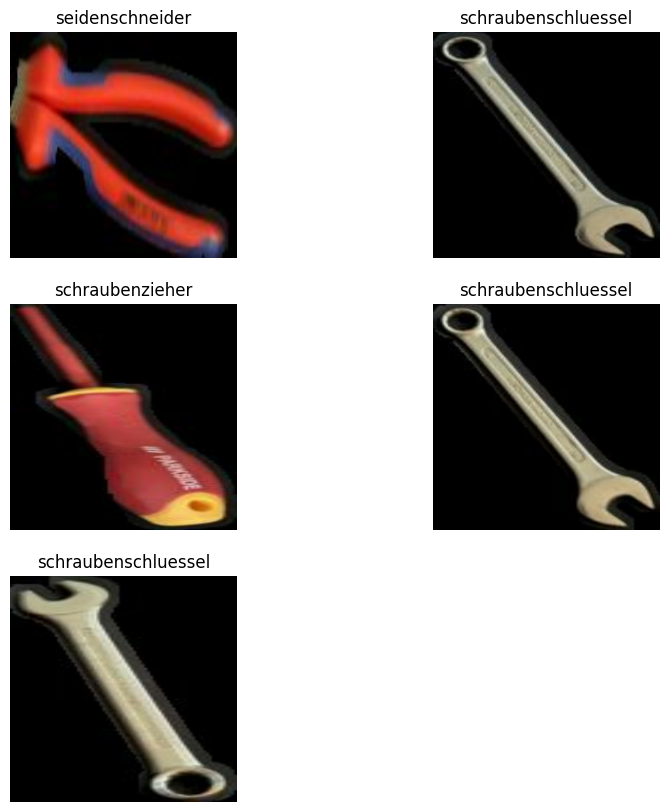

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 2, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.title(class_names[labels[i]])
        plt.axis("off")

Die folgende Zelle versucht, die Hardware gut auszulasten. Es gäbe [viel dazu zu sagen](https://www.tensorflow.org/guide/data_performance), aber sagen wir einfach, dass die Daten für einen raschen Zugriff vorbereitet werden:

In [186]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Nun definieren wir unser Modell! Die Modell-Definitionen wurden in separate Skripte ausgelagert (`model_simple_cnn.py` und `model_transfer_learning.py`).

**Standard: Transfer Learning** (funktioniert auch mit wenig Daten)  
**Alternative: Einfaches CNN** (auskommentiert, funktioniert schlecht bei <100 Bildern)

Wichtig ist, dass `num_classes` stimmt, die Anzahl der Klassen und gleichzeitig die Anzahl Neuronen in der letzten (Ausgabe-)Schicht. Und natürlich die Grösse des Eingabebildes, `image_size`. 

## 1. Training Simple CNN

Einfaches Convolutional Neural Network mit 3 Conv2D-Schichten. Funktioniert gut bei ausreichend Daten.

**Script:** `scripts/train_simple_cnn.py`


### Scripte


In [187]:
from train_simple_cnn import train_simple_cnn

model1, history1 = train_simple_cnn(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name="model_" + Datensatzname1,
    epochs=50
)


Epoch 1/50


c:\Users\mirko\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4372 - loss: 1.1746
Epoch 1: val_accuracy improved from None to 0.59649, saving model to checkpoints\model_Werkzeuge_simple_cnn_best.keras

Epoch 1: finished saving model to checkpoints\model_Werkzeuge_simple_cnn_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - accuracy: 0.5498 - loss: 0.9820 - val_accuracy: 0.5965 - val_loss: 0.6134
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7474 - loss: 0.5055
Epoch 2: val_accuracy improved from 0.59649 to 0.89474, saving model to checkpoints\model_Werkzeuge_simple_cnn_best.keras

Epoch 2: finished saving model to checkpoints\model_Werkzeuge_simple_cnn_best.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.7965 - loss: 0.4298 - val_accuracy: 0.8947 - val_loss: 0.2550
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9595 - loss: 0.1796
Epoch 3: val_accuracy improved from 0.89474 to 0.91228, saving model to checkpoints\model_Werkzeuge_simple_cnn_best.ke

## Ergebnisse


### Übersicht über Werte als Plot

Der folgende Graph zeigt den Trainingsverlauf des Modells über alle Epochen:

**Vier Kurven werden dargestellt:**

1. **Training Accuracy (acc)** - Zeigt, wie gut das Modell die Trainingsdaten klassifiziert
   - Sollte im Laufe des Trainings steigen (Modell lernt)
   - Hohe Werte (nahe 1.0 = 100%) bedeuten, dass das Modell die Trainingsbilder gut erkennt

2. **Validation Accuracy (val_acc)** - Zeigt, wie gut das Modell auf neuen, ungesehenen Daten (Validierungsdaten) performt
   - Wichtig für die Generalisierungsfähigkeit des Modells
   - Sollte ähnlich zur Training Accuracy sein (sonst Overfitting)

3. **Training Loss (loss)** - Zeigt den Fehler auf den Trainingsdaten
   - Sollte im Laufe des Trainings sinken (weniger Fehler = besser)
   - Niedrige Werte sind besser

4. **Validation Loss (val_loss)** - Zeigt den Fehler auf den Validierungsdaten
   - Sollte ebenfalls sinken
   - Wenn val_loss steigt, während loss sinkt → Overfitting (Modell merkt sich Trainingsdaten statt zu lernen)

**Was man im Graph erkennen sollte:**
- Beide Accuracy-Kurven sollten steigen und nahe beieinander liegen
- Beide Loss-Kurven sollten sinken und nahe beieinander liegen
- Große Unterschiede zwischen Training und Validation deuten auf Overfitting hin

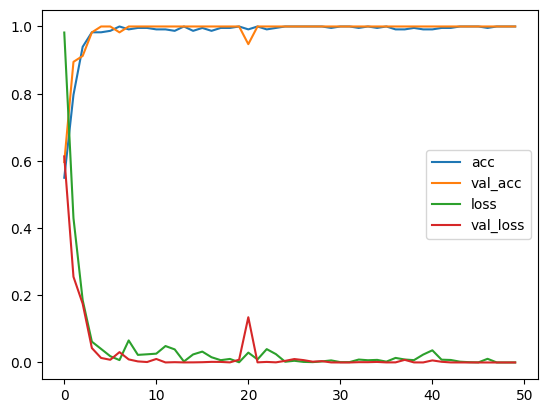

In [188]:
plt.plot(history1.history['accuracy'],label='acc')
plt.plot(history1.history['val_accuracy'],label='val_acc')
plt.plot(history1.history['loss'],label='loss')
plt.plot(history1.history['val_loss'],label='val_loss')
plt.legend()

### Übersicht über Werte in 2 Plots

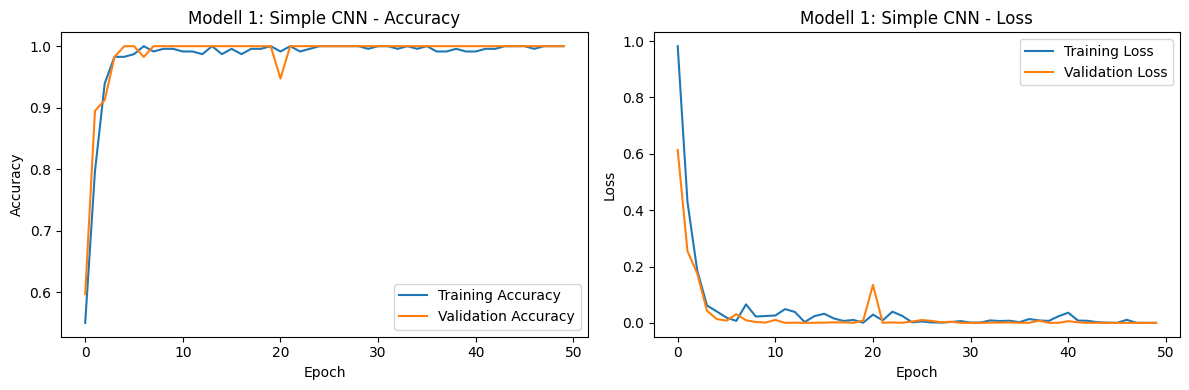

Finale Training Accuracy: 1.0000
Finale Validation Accuracy: 1.0000


In [189]:
# Training History plotten
import matplotlib.pyplot as plt

# Prüfe ob history1 verfügbar ist (Modell 1 wird mit train_simple_cnn_model trainiert)
if 'history1' in globals():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Training Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Modell 1: Simple CNN - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Training Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Modell 1: Simple CNN - Loss')
    plt.tight_layout()
    plt.show()

    # Finale Metriken
    final_train_acc = history1.history['accuracy'][-1]
    final_val_acc = history1.history['val_accuracy'][-1]
    print(f"Finale Training Accuracy: {final_train_acc:.4f}")
    print(f"Finale Validation Accuracy: {final_val_acc:.4f}")
else:
    print("⚠ Warnung: 'history1' ist nicht definiert.")
    print("  Modell 1 (Simple CNN) wurde noch nicht trainiert.")
    print("  → Führen Sie zuerst Zelle 45 aus, um Modell 1 zu trainieren (train_simple_cnn_model).")


Wie wir sehen wurden Training und Validation Accuracy mit 1 abgeschlossen. die gewählten 50 Epochen sind absolut ausreichend. Keine Veränderung zu 4. 

##Validierung

Nun starten wir die Validierung mit den 20% Validierungsdaten im Training. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


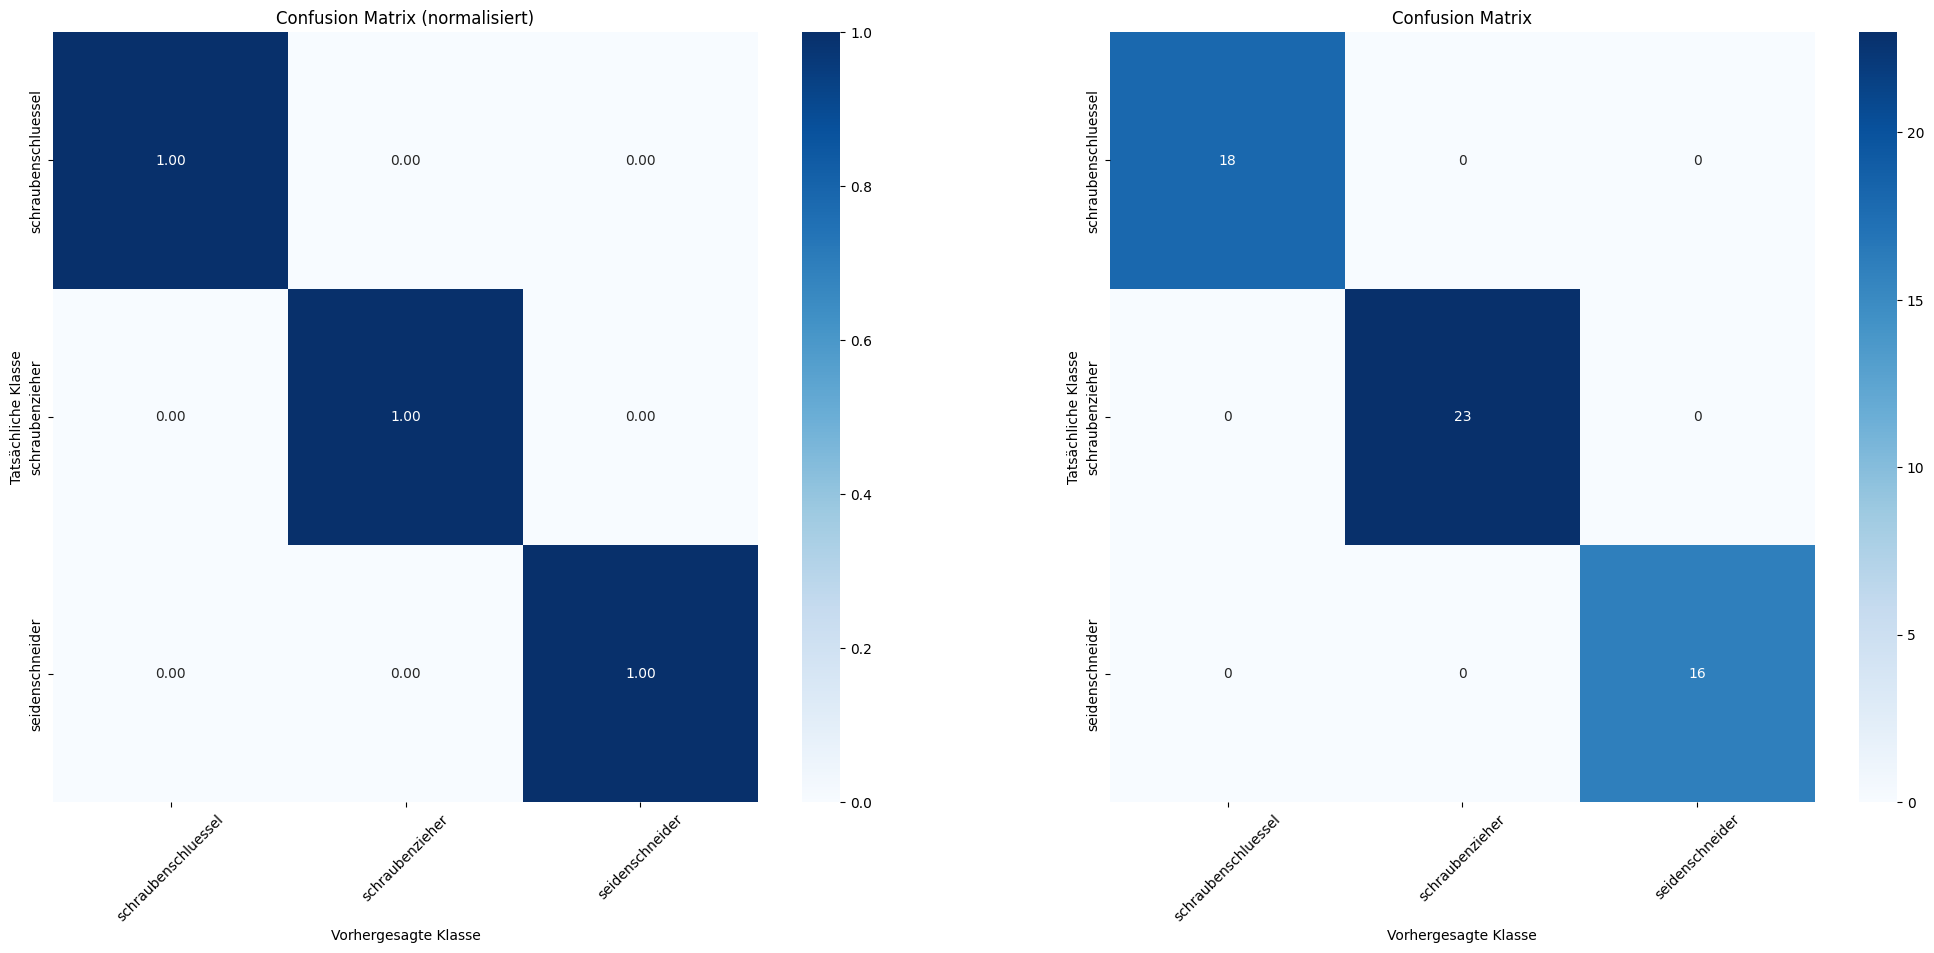

In [190]:
y = np.asarray(list(val_ds.unbatch().map(lambda x, y: y)))
y.shape

yhat = model1.predict(val_ds)
yhatnum = yhat.argmax(axis=1)
yhatnum

y_str = np.array(class_names)[y]
yhat_str = np.array(class_names)[yhatnum]

fig,axlist = plt.subplots(1,2,figsize=(25,10));
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True,ax=axlist[0]);axlist[0].tick_params(axis='x', rotation=45)
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=False,ax=axlist[1]);axlist[1].tick_params(axis='x', rotation=45)

In [191]:
Keras_Dateiname = f'model_{Datensatzname1}.keras'
voller_Keras_Dateiname = str(Path(model_output_path)/Keras_Dateiname)
print(voller_Keras_Dateiname)
model = tf.keras.models.load_model(voller_Keras_Dateiname)

model_output\model\model_Werkzeuge_simple_cnn.keras


In [192]:
ser = pd.Series(train_or_test)
ser

IMG_2125.JPEG    train
IMG_2128.JPEG    train
IMG_2129.JPEG    train
IMG_2130.JPEG    train
IMG_2131.JPEG    train
                 ...  
IMG_2104.JPEG     test
IMG_2118.JPEG     test
IMG_2119.JPEG     test
IMG_2121.JPEG     test
IMG_2537.JPEG     test
Length: 360, dtype: object

In [193]:
ser.to_csv('train_test_split.csv')
ser.value_counts()

train    288
test      72
Name: count, dtype: int64

Soweit so gut. Schauen wir nun die Tests an. 
Weiter geht's mit dem Notebook [semesterarbeit-evaluation.ipynb](semesterarbeit-evaluation.ipynb). Dort wollen wir die Performanz eines Modells evaluieren.